# Projet 8 - Déployer un modèle dans le cloud

La jeune start-up de l'AgriTech, nommée  "Fruits!" cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents.
La start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.<br>
Nous avons à disposition un jeu de données constitué des images de fruits et des labels associés. 

Nous avons également un notebook réalisé par l'alternant qui peut servir de point de départ pour construire une partie de la chaîne de traitement des données.

##  Objectifs dans ce projet

1. Développer une première chaîne de traitement des données qui <br />
   comprendra le **preprocessing** et une étape de **réduction de dimension**.
2. Tenir compte du fait que <u>le volume de données va augmenter <br />
   très rapidement</u> après la livraison de ce projet, ce qui implique de:
 - Déployer le traitement des données dans un environnement **Big Data**
 - Développer les scripts en **pyspark** pour effectuer du **calcul distribué**

## Déroulement des étapes du projet

Le projet va être réalisé en 2 temps, dans deux environnements différents. <br />
Nous allons dans un premier temps développer et exécuter notre code en local, <br />
en travaillant sur un nombre limité d'images à traiter.

Une fois les choix techniques validés, nous déploierons notre solution <br />
dans un environnement Big Data en mode distribué.


## Choix techniques généraux retenus

###  Calcul distribué

PySpark est une alternative plus puissante que Pandas Python. Il permet de faire des calculs en temps réel sur une grande quantité de données car il se concentre sur le traitement en mémoire. Il présente une faible latence.
PySpark nous permet d’atteindre une grande vitesse de traitement des données, qui est environ 100 fois plus rapide en mémoire et 10 fois plus rapide sur le disque.

### Transfert Learning

Nous utiliserons le modèle **MobileNetV2** qui a déjà eté entrainé pour l'adapter à notre problématique.  
Nous allons fournir au modèle nos images, et nous allons
<u>récupérer l'avant dernière couche</u> du modèle.<br />
En effet la dernière couche de modèle est une couche softmax 
qui permet la classification des images ce que nous ne 
souhaitons pas dans ce projet.

L'avant dernière couche correspond à un **vecteur 
réduit** de dimension (1,1,1280).

Cela permettra de réaliser une première version du moteur pour la classification des images des fruits.

## Déploiement de la solution en local


### Importation des librairies <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Image
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
import io
from PIL import Image

In [2]:

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark import SparkContext

2023-10-19 14:06:37.611365: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-19 14:06:37.657517: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-19 14:06:37.657554: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-19 14:06:37.657580: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-19 14:06:37.665615: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-19 14:06:38.841637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [3]:
import pyspark
print(pyspark.__version__)

import py4j
print(py4j.__version__)

3.5.0
0.10.9.7


### Définition des PATH pour charger les images et enregistrer les résultats

Dans un 1er temps , je vais afficher une image de chaque sous-répertoire contenu dans le dossier training
On stocke le nom  des sous-répertoires de "training" dans la variable image. Ensuite, on affiche la première image de chaque sous-répertoire.

Dans cette version locale nous partons du principe que les données sont stockées dans le même répertoire que le notebook.  
J'ai utilisé un extrait de 472 images à traiter dans cette première version en local.Ce qui correspond aux 3ers sous-répertoires que j'ai extrait et stocké dans le dossier **"Test1"**.  
le résultat de notre traitement est enregistré dans le dossier **"Resultat"**

In [4]:
PATH = os.getcwd()
PATH_Data = PATH+'/data/Test1/'
PATH_Result = PATH+'/data/Resultat/'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /home/sd/Documents/DATA_SCIENTIST/P8
PATH_Data:   /home/sd/Documents/DATA_SCIENTIST/P8/data/Test1/
PATH_Result: /home/sd/Documents/DATA_SCIENTIST/P8/data/Resultat/


## PySpark

Dans cette section, on va travailler avec les images avec PySpark.

PySpark est une alternative plus puissante que Pandas Python. Il permet de faire des calculs en temps réel sur une grande quantité de données car il se concentre sur le traitement en mémoire. Il présente une faible latence.<br>
PySpark nous permet d’atteindre une grande vitesse de traitement des données, qui est environ 100 fois plus rapide en mémoire et 10 fois plus rapide sur le disque.

On met les chemins dans les variables. Ici comme le travail se fait en local, on est donc limité en puissance, on va faire le travail sur deux fruits : les noix et les pastèques. Pour enregistrer nos résultats, on créait un nouveau dossier.

In [5]:
#pip install findspark


In [6]:
#Ici on affiche les liens où sont stockées les données contenant le mot SPARK

for o, v in sorted(os.environ.items()):
    if "SPARK" in o.upper():
        print("{0:25}= {1}".format(o, v.replace(os.environ["USERNAME"], "<username>")))

PYSPARK_DRIVER_PYTHON    = /home/<username>/anaconda3/bin/python
PYSPARK_PYTHON           = /home/<username>/anaconda3/bin/python
SPARK_AUTH_SOCKET_TIMEOUT= 15
SPARK_BUFFER_SIZE        = 65536
SPARK_HOME               = /opt/spark


##  Création de la SparkSession

Apache spark est un moteur de traitement de données rapide dédié au big data.Il permet d'effectuer de larges volumes de données de manière distribuée (cluster computing)Des principaux avantages sont sa vitesse,sa simplicité d'utilisation et sa polyvalence.C'est un moteur de traitement parallèle de données open source permettant d'effectuer des analyses de grande envergure par le biais de machines en clusters.


L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé **SparkSession**. <br />
<u>Une instance de **SparkSession** est la façon dont Spark exécute les fonctions définies par l’utilisateur <br />
dans l’ensemble du cluster</u>. <u>Une SparkSession correspond toujours à une application Spark</u>.

<u>Ici nous créons une session spark en spécifiant dans l'ordre</u> :
 1. un **nom pour l'application**, qui sera affichée dans l'interface utilisateur Web Spark "**P8**"
 2. que l'application doit s'exécuter **localement**. <br />
   Nous ne définissons pas le nombre de cœurs à utiliser (comme .master('local[4]) pour 4 cœurs à utiliser), <br />
   nous utiliserons donc tous les cœurs disponibles dans notre processeur.<br />
 3. une option de configuration supplémentaire permettant d'utiliser le **format "parquet"** <br />
   que nous utiliserons pour enregistrer et charger le résultat de notre travail.
 4. vouloir **obtenir une session spark** existante ou si aucune n'existe, en créer une nouvelle

In [7]:
spark = SparkSession\
             .builder\
             .appName('P8')\
             .master('local')\
             .config("spark.sql.parquet.writeLegacyFormat", 'true')\
             .getOrCreate()

23/10/19 14:06:43 WARN Utils: Your hostname, sd-K95VB resolves to a loopback address: 127.0.1.1, but we couldn't find any external IP address!
23/10/19 14:06:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/19 14:06:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/19 14:06:44 WARN MacAddressUtil: Failed to find a usable hardware address from the network interfaces; using random bytes: 8a:65:72:d8:e0:93:f9:d1
23/10/19 14:06:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/10/19 14:06:44 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Résumé de notre modèle Spark

In [8]:
spark

On crée également la variable sc, un sparkContext issu de la variable spark.<br>Sc est un objet qui indique à Spark comment accéder à un cluster pour éxécuter les commandes.
sparkContext est le point d'accès de toutes les fonctionnalités de Spark, il est utilisé par exemple, pour créer des programmes Spark RDD (Resilient distributed datasets ) qui sont des ensembles de données diverses dont la taille est si grande qu'ils ne tiennet pas dans un seul noeud et doivent être partagés entre plusieurs noeuds.
des "accumulateurs et des variables de dissusion sur le cluster (qu'on appelle des broadcast variables).

In [9]:
sc = spark.sparkContext

### 3.7.1 Chargement des données

Les images sont chargées au format binaire, ce qui offre, <br />
plus de souplesse dans la façon de prétraiter les images.

Avant de charger les images, nous spécifions que nous voulons charger <br />
uniquement les fichiers dont l'extension est **jpg**.

Nous indiquons également de charger tous les objets possibles contenus <br />
dans les sous-dossiers du dossier communiqué.



In [10]:
images = spark.read.format("binaryFile") \
                    .option("pathGlobFilter", "*.jpg") \
                    .option("recursiveFileLookup", "true") \
                    .load(PATH_Data)

Dans le code ci-dessous, on va crée un tableau avec :
- le chemin de l'image,
- l'heure de modification de l'image,
- la taille de l'image,
- son contenue et son label

Je n'affiche que le label et le chemin de l'image

In [11]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(10,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None


+-------------------------------------------------------------------------------+--------------+
|path                                                                           |label         |
+-------------------------------------------------------------------------------+--------------+
|file:/home/sd/Documents/DATA_SCIENTIST/P8/data/Test1/Apple Golden 1/114_100.jpg|Apple Golden 1|
|file:/home/sd/Documents/DATA_SCIENTIST/P8/data/Test1/Apple Golden 1/103_100.jpg|Apple Golden 1|
|file:/home/sd/Documents/DATA_SCIENTIST/P8/data/Test1/Apple Golden 1/101_100.jpg|Apple Golden 1|
|file:/home/sd/Documents/DATA_SCIENTIST/P8/data/Test1/Apple Golden 1/96_100.jpg |Apple Golden 1|
|file:/home/sd/Documents/DATA_SCIENTIST/P8/data/Test1/Apple Golden 1/100_100.jpg|Apple Golden 1|
|file:/home/sd/Documents/DATA_SCIENTIST/P8/data/Test1/Apple Golden 1/121_100.jpg|Apple Golden 1|
|file:/home/sd/Documents/DATA_SCIENTIST/P8/data/Test1/Apple Golden 1/113_100.jpg|Apple Golden 1|
|file:/home/sd/Documents/DATA_

On utilise  MobileNetV2. Un modèle plus rapide que VGG16.<br>
Nous chargeons le modèle MobileNetV2 avec les poids précalculés issus d'imagenet et en spécifiant le format de nos images en entrée. On retira la dernière couche du modèle.
- En entrée : l'entrée du modèle MobileNetV2
- En sortie : l'avant dernière couche du modèle MobileNetV2

In [12]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

Création du modèle

In [13]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

Résumée du modèle :

In [14]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

 Lorsqu'on exécute un RDD Spark, des travaux DataFrame dont les variables de diffusion sont définies et utilisées, Spark effectue les opérations suivantes.<br>

- Spark décompose le travail en étapes qui ont distribué le brassage et les actions sont exécutées avec dans l'étape.
- Les étapes ultérieures sont également divisées en tâches
- Spark diffuse les données communes (réutilisables) nécessaires aux tâches de chaque étape.
- Les données diffusées sont mises en cache au format sérialisé et désérialisées avant l'exécution de chaque tâche.

In [15]:
brodcast_weights = sc.broadcast(new_model.get_weights())
brodcast_weights

La suite sera mis sous fonction

In [16]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

On utilise udf :
- pour créer une variable feature d'images en pd.Series,
- pré-traiter les images.

In [17]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/sd/anaconda3/lib/python3.11/site-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


Nous pouvons maintenant exécuter la featurisation sur l'ensemble de notre DataFrame Spark.
REMARQUE : Cela peut prendre beaucoup de temps, tout dépend du volume de données à traiter.

Notre jeu de données de Test contient 22819 images.
Cependant, dans l'exécution en mode local,
nous traiterons un ensemble réduit de 472 images.


In [18]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )
features_df.show(5)
features_df.printSchema()

2023-10-17 11:14:23.783960: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 11:14:23.826934: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-17 11:14:23.826995: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-17 11:14:23.827022: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-17 11:14:23.834421: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 11:14:24.874705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

+--------------------+------------------+--------------------+
|                path|             label|            features|
+--------------------+------------------+--------------------+
|file:/home/sd/Doc...|    Apple Golden 1|[0.0, 0.015513906...|
|file:/home/sd/Doc...|    Apple Golden 1|[0.0, 0.011019239...|
|file:/home/sd/Doc...|    Apple Golden 1|[0.0, 0.009420843...|
|file:/home/sd/Doc...|Apple Crimson Snow|[0.0, 0.0, 0.0, 0...|
|file:/home/sd/Doc...|Apple Crimson Snow|[0.0, 0.0, 0.0, 0...|
+--------------------+------------------+--------------------+
only showing top 5 rows

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



1/1 [==============================] - 1s 1s/step


Nous avons maintement nos images, la colonne la plus importante est la colonne "features". On va enregistrer maintenant nos données dans la dossier résultat.

In [19]:
print(PATH_Result)

/home/sd/Documents/DATA_SCIENTIST/P8/data/Resultat/


Enregistrement des données traitées au format "parquet"

In [20]:
features_df.write.mode("overwrite").parquet(PATH_Result)

2023-10-17 11:14:31.310413: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 11:14:31.352414: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-17 11:14:31.352461: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-17 11:14:31.352487: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-17 11:14:31.359562: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 11:14:32.334772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

On lit notre nouveau tableau au format dataframe pandas.

In [21]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')
df.head(3)

,path,label,features
0,file:/home/sd/Documents/DATA_SCIENTIST/P8/data...,Apple Golden 1,"[0.0, 0.015513906, 0.93827647, 0.0, 0.0, 0.0, ..."
1,file:/home/sd/Documents/DATA_SCIENTIST/P8/data...,Apple Golden 1,"[0.0, 0.011019239, 1.1527871, 0.0, 0.0, 0.0, 0..."
2,file:/home/sd/Documents/DATA_SCIENTIST/P8/data...,Apple Golden 1,"[0.0, 0.009420843, 0.0, 0.0, 0.116314754, 0.0,..."


In [22]:
df.loc[0,'features'].shape

(1280,)

### Analyse en Composantes Principales

La propriété de L'ACP de capter une partie importante de la variance des données à partir de moins de variables est particulièrement intéressante dans le domaine du mMachine Learnig pour être capable de fournir des prédictions avec des modèles plus légers (car utiliszant moins de variables et des résultats aussi performants.

On va effectuer une ACP sur  le dataframe au format pyspark.<br>
pour cela , on va :
- mettre au format vecteur la colonne "features"
- standaridiser les résultats
- PCA

L'étape de vectorisation .

In [23]:
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.sql.functions import udf
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
tab = features_df.withColumn('features', ud_f('features'))
tab.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)



La standardisation des données.On passe par une normalisation centrée-réduite.

In [24]:
from pyspark.ml.feature import StandardScaler
standardizer = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                                  withStd=True, withMean=True)
model_std = standardizer.fit(tab)
tab = model_std.transform(tab)
tab.show(10)

1/1 [==============================] - 1s 1s/step==============>  (19 + 1) / 20]


+--------------------+------------------+--------------------+--------------------+
|                path|             label|            features|      scaledFeatures|
+--------------------+------------------+--------------------+--------------------+
|file:/home/sd/Doc...|    Apple Golden 1|[0.0,0.0155139062...|[-0.7222445622085...|
|file:/home/sd/Doc...|    Apple Golden 1|[0.0,0.0110192392...|[-0.7222445622085...|
|file:/home/sd/Doc...|    Apple Golden 1|[0.0,0.0094208428...|[-0.7222445622085...|
|file:/home/sd/Doc...|Apple Crimson Snow|[0.0,0.0,0.0,0.0,...|[-0.7222445622085...|
|file:/home/sd/Doc...|Apple Crimson Snow|[0.0,0.0,0.0,0.0,...|[-0.7222445622085...|
|file:/home/sd/Doc...|Apple Crimson Snow|[0.0,0.0017438519...|[-0.7222445622085...|
|file:/home/sd/Doc...|    Apple Golden 1|[2.35216954024508...|[-0.7217285098211...|
|file:/home/sd/Doc...|    Apple Braeburn|[1.03829753398895...|[1.55572015111526...|
|file:/home/sd/Doc...|Apple Crimson Snow|[0.02568235248327...|[-0.6658989668

1/1 [==============================] - 1s 856ms/step


Le calcul de l'ACP 

In [25]:
from pyspark.ml.feature import PCA
n_components = 250
pca = PCA(k=n_components, inputCol='scaledFeatures', outputCol='pcaFeatures')
model = pca.fit(tab)
tab_pca = model.transform(tab)

2023-10-17 11:16:31.396864: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 11:16:31.445200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-17 11:16:31.445238: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-17 11:16:31.445263: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-17 11:16:31.452323: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 11:16:32.356931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [27]:
def display_scree_plot(pca):
    plt.figure(figsize=(10,8))
    val_limite=80
    scree=pca.explainedVariance*100
    plt.bar(np.arange(len(scree))+1,scree)
    plt.plot(np.arange(len(scree))+1,scree.cumsum(),c="green",marker="o")
    plt.axhline(y=val_limite, color='r', linestyle='-')
    plt.xlabel("nombre de composants")
    plt.ylabel("pourcentage de variance expliquée")
    plt.title("Variance par Composant")
    plt.show(block=False)


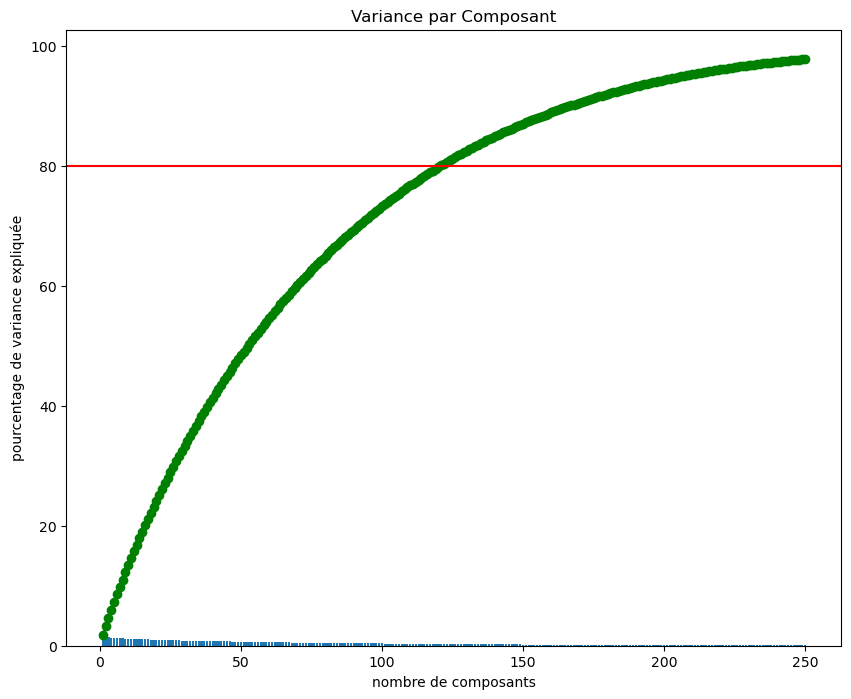

In [28]:
display_scree_plot(model)

en réduisant le nombre de composantes à 120 , on conserve 80% de la variance du modèle.

In [29]:
var = model.explainedVariance.cumsum()
print("Le choix du nombre de dimensions est : ",var[var <=val_limite].shape[0])

Le choix du nombre de dimensions est :  120


On réduit donc 

In [31]:
n_components = var[var <=val_limite].shape[0]
pca = PCA(k=n_components, inputCol='scaledFeatures', outputCol='pcaFeatures')
model_pca = pca.fit(tab)
tab = model_pca.transform(tab)
tab.show(10)
tab.printSchema()

1/1 [==============================] - 1s 1s/step==============>  (19 + 1) / 20]
23/10/17 11:21:27 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB


+--------------------+------------------+--------------------+--------------------+--------------------+
|                path|             label|            features|      scaledFeatures|         pcaFeatures|
+--------------------+------------------+--------------------+--------------------+--------------------+
|file:/home/sd/Doc...|    Apple Golden 1|[0.0,0.0155139062...|[-0.7222445622085...|[19.7732356424416...|
|file:/home/sd/Doc...|    Apple Golden 1|[0.0,0.0110192392...|[-0.7222445622085...|[18.7087011815165...|
|file:/home/sd/Doc...|    Apple Golden 1|[0.0,0.0094208428...|[-0.7222445622085...|[16.8471485291677...|
|file:/home/sd/Doc...|Apple Crimson Snow|[0.0,0.0,0.0,0.0,...|[-0.7222445622085...|[-1.3920964370762...|
|file:/home/sd/Doc...|Apple Crimson Snow|[0.0,0.0,0.0,0.0,...|[-0.7222445622085...|[-2.0005504494461...|
|file:/home/sd/Doc...|Apple Crimson Snow|[0.0,0.0017438519...|[-0.7222445622085...|[-3.5822237461923...|
|file:/home/sd/Doc...|    Apple Golden 1|[2.35216954024

1/1 [==============================] - 1s 1s/step


Pour enregistrer au format csv, on va convertir, les colonnes de vecteur en string

In [32]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, StructType, StructField, IntegerType

def array_to_string(my_list):
    return '[' + ','.join([str(elem) for elem in my_list]) + ']'

array_to_string_udf = udf(array_to_string, StringType())

df_1 = tab.withColumn('features', array_to_string_udf(tab["features"]))
df_1 = df_1.withColumn('scaledFeatures', array_to_string_udf(df_1["scaledFeatures"]))
df_1 = df_1.withColumn('pcaFeatures', array_to_string_udf(df_1["pcaFeatures"]))
df_1.show(10)
df_1.printSchema()

23/10/17 11:21:31 WARN DAGScheduler: Broadcasting large task binary with size 1296.7 KiB
1/1 [==============================] - 1s 974ms/step                (0 + 1) / 1]


+--------------------+------------------+--------------------+--------------------+--------------------+
|                path|             label|            features|      scaledFeatures|         pcaFeatures|
+--------------------+------------------+--------------------+--------------------+--------------------+
|file:/home/sd/Doc...|    Apple Golden 1|[0.0,0.0155139062...|[-0.7222445622085...|[19.7732356424416...|
|file:/home/sd/Doc...|    Apple Golden 1|[0.0,0.0110192392...|[-0.7222445622085...|[18.7087011815165...|
|file:/home/sd/Doc...|    Apple Golden 1|[0.0,0.0094208428...|[-0.7222445622085...|[16.8471485291677...|
|file:/home/sd/Doc...|Apple Crimson Snow|[0.0,0.0,0.0,0.0,...|[-0.7222445622085...|[-1.3920964370762...|
|file:/home/sd/Doc...|Apple Crimson Snow|[0.0,0.0,0.0,0.0,...|[-0.7222445622085...|[-2.0005504494461...|
|file:/home/sd/Doc...|Apple Crimson Snow|[0.0,0.0017438519...|[-0.7222445622085...|[-3.5822237461923...|
|file:/home/sd/Doc...|    Apple Golden 1|[0.00023521695

Le dernier point est l' enregistrement du fichier au format csv.

In [33]:
df_1.write.mode("overwrite").parquet("Features")

23/10/17 11:21:35 WARN DAGScheduler: Broadcasting large task binary with size 1488.3 KiB
2023-10-17 11:21:36.217004: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 11:21:36.259852: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-17 11:21:36.259903: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-17 11:21:36.259929: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-17 11:21:36.267024: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2

In [34]:
df_2 = pd.read_parquet("Features", engine='pyarrow')
df_2.head(3)

,path,label,features,scaledFeatures,pcaFeatures
0,file:/home/sd/Documents/DATA_SCIENTIST/P8/data...,Apple Golden 1,"[0.0,0.015513906255364418,0.938276469707489,0....","[-0.7222445622085311,-0.5420478998034728,3.809...","[19.773235642441673,1.8096836118339223,0.08654..."
1,file:/home/sd/Documents/DATA_SCIENTIST/P8/data...,Apple Golden 1,"[0.0,0.011019239202141762,1.1527870893478394,0...","[-0.7222445622085311,-0.5834274930938889,4.776...","[18.708701181516517,-0.7642404965702793,-0.807..."
2,file:/home/sd/Documents/DATA_SCIENTIST/P8/data...,Apple Golden 1,"[0.0,0.009420842863619328,0.0,0.0,0.1163147538...","[-0.7222445622085311,-0.5981429302156499,-0.41...","[16.847148529167757,0.3214952794033032,0.63297..."


In [35]:
df_2.to_csv("Features.csv")

On a validé le processus sur un jeu de données allégé en local
où nous avons simulé un cluster de machines en répartissant la charge de travail
sur différents cœurs de processeur au sein d'une même machine.

Nous allons maintenant généraliser le processus en déployant notre solution
sur un réel cluster de machines et nous travaillerons désormais sur la totalité
des 22819 images de notre dossier "Test".


# Déployement de la solution sur le web

 le prestataire **Amazon Web Service** sera utilisé pour le déployement en passant par une Solution PAAS (Plateforme As A Service) qui permet de louer des instances **EC2** avec des applications préinstallées et configurées .
 
 Il s'agit du service **EMR** qui offrent différents avantages comme la facilité et la rapidité de mise en oeuvre , des solutions matérielles et logicielles optimisées pour les ingénieurs d'AWS, une stabiité de la solution et des mises à jours des packages utilisés à chaque nouvelle instanciation.
    
Les données seront stockées sur **Amazon S3**. (S3 pour Amazon Simple Storage Service.)

## Préambule  au déployement sur le web

Une inscription sur **AWS** est nécessaire pour obtenir un accès. L'utilisation des services est payant . Il faut résilier les instances avant de quitter car le temps est facturé même si elles ne sont pas utilisées.

Installation de **AWScli** qui est l' interface en ligne de commande d'AWS.

Il faut créé une paire de clés pour se connecter sans saisir systématiquement le login/mot de passe.

Il faut également configurer l'accès SSH à nos  serveurs EC2. Ici aussi, via un système de clés qui nous dispense de devoir nous authentifier "à la main" à chaque connexion.

Il faut ensuite uploader les données de travail sur **Amazon S3** après avoir créer un **bucket sur S3** :  **aws s3 mb s3://p8-data-sd**

On copie ensuite le contenu du dossier **"Test**  dans un répertoire **Test** sur notre bucket "p8-data":

1. On se place à l'intérieur du répertoire **Test**
2. **aws sync . s3://p8-data-sd/Test**

La commande **sync** est utile pour synchroniser deux répertoires.

<u>Les données du projet sont maintenant disponibles sur Amazon S3</u>.

### La configuration du serveur EMR

après avoir créé le cluster , il faut sélectionné les logiciels nécessaires au projet :la dernière version d' EMR, Hadoop, spark , jupyperhub et Tensorflow pour réaliser le transfert learning.

Pour paramétrer l'application afin que les notebooks,comme le reste de nos données de travail, soient enregistrés directement sur S3 :
Créer un cluster
Pour ouvrir et enregistrer les notebooks non pas sur l'espace disque de l'instance EC2 (comme ce serait le cas dans la configuration par défaut de JupyterHub) mais directement sur Amazon S3 , on peut créer un fichier JSON lors de la création de la première instance EMR, 

Voici le contenu du fichier JSON : [{"classification":"jupyter-s3-conf","properties":{"s3.persistence.bucket":"data-p8-sd","s3.persistence.enabled":"true"}}] 


#### Le choix des instances :

 - les instances de type M5 qui sont des instances de type équilibrés
 - le type xlarge qui est l'instance la moins onéreuse disponible 
 - 1 instance Maître (le driver) et 2 instances Principales (les workeurs)soit un total de 3 instance EC2.
 
#### Les actions d'amorçage 
 
Création d'un fichier **"bootstrap-emr.sh"** qui sera uploader sur S3  à la racine du bucket "p8-data"-sd" et ajouté dans les **actions d'amorcage** .il s'agit simplement de commandes "pip install" pour installer les bibliothèques manquantes comme réalisé en local.

#### La sécurité

A cette étape ,il faut sélectionner la paire de clés EC2 créé précédemment qui nous permettra de se connecter en ssh à nos instances EC2 sans avoir à entrer nos login/mot de passe.
On laisse les autres paramètres par défaut. 

####  L' instanciation du serveur
Cette étape peut durer 15 à 20 minutes
Plusieurs étapes s'enchaîne, on peut suivre l'avancé du statut du **cluster EMR**  
Lorsque le statut affiche en vert: "**En attente**" cela signifie que l'instanciation s'est bien déroulée et que notre serveur est prêt à être utilisé</u>.

####  La création du tunnel SSH à l'instance EC2 (Maître)

   1 .Création des autorisations sur les connexions entrantes
   Les applications ne sont accessibles que depuis le réseau local du driver et pour y accéder il faut **créer un tunnel SSH vers le driver**.

Par défaut, ce driver se situe derrière un firewall qui bloque l'accès en SSH. Pour ouvrir le port 22 qui correspond au port sur lequel écoute le serveur SSH, il faut modifier le **groupe de sécurité EC2 du driver**.
cliquez sur "Groupes de sécurité". <br />
Il faut modifier le groupe de sécurité d’ElasticMapReduce-Master.Dans l'onglet "Entrant", ajoutez une règle SSH dont la source est "N'importe où" (ou "Mon IP" si vous disposez d'une adresse IP fixe).*

####  La création du tunnel SSH vers le Driver

Pour ce faire,il faut utiliser la commande suivante dans un terminal pour établir un tunnel ssh (seul l'URL change d'une instance à une autre): 
"**ssh -i ~/cles_p8_sd.pem hadoop@ec2-35-181-168-120.eu-west-3.compute.amazonaws.com**"
On inscrit "**yes**" pour valider la connexion et si     la connexion est établit on obtient l'affichage de la console EMR

#### La configuration de FoxyProxy
 ajouter un proxy appelé EMR à l'adresse : localhost , de type SOCKS5 , sur le port 5555


#### L' accès aux applications du serveur EMR via le tunnel ssh
Pour ce faire,il faut utiliser la commande suivante dans un terminal pour établir un tunnel ssh (seul l'URL change d'une instance à une autre): 
**ssh -i ~/.ssh/p8-p8-sd.pem -D 5555 hadoop@ec2-35-180-91-39.eu-west-3.compute.amazonaws.com**"

####  Connexion au notebook JupyterHub

On se connecte avec les informations par défaut:
 - login: **jovyan**
 - password: **jupyter**
 
 Avant de commencer ,il faut s'assurer d'utiliser le **kernel pyspark**.En utilisant ce kernel, une session spark est créée à l'exécution de la première cellule**. 
 
Il n'est donc **plus nécessaire d'exécuter le code "spark = (SparkSession ..."** comme lors de l'exécution de notre notebook en local sur notre linux Ubuntu

#### Démarrage de la session SPARK

In [1]:
# Démarrage de l'application Spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1697651615794_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Affichage des informations sur la session en cours er liens vers Spark UI

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1697651615794_0002,pyspark,idle,Link,Link,None,✔


#### import des librairies

In [3]:

import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

###  Définition des PATH pour charger les images et enregistrer les résultats

Nous accédons directement à nos **données sur S3** comme si elles étaient **stockées localement**.

In [4]:
PATH = 's3://data-p8-sd'
PATH_Data = PATH+'/Test'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://data-p8-sd
PATH_Data:   s3://data-p8-sd/Test
PATH_Result: s3://data-p8-sd/Results

###  Traitement des données

####  Chargement des données

In [5]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://data-p8-sd/T...|2023-10-16 13:33:11|  7353|[FF D8 FF E0 00 1...|
|s3://data-p8-sd/T...|2023-10-16 13:33:11|  7350|[FF D8 FF E0 00 1...|
|s3://data-p8-sd/T...|2023-10-16 13:33:11|  7349|[FF D8 FF E0 00 1...|
|s3://data-p8-sd/T...|2023-10-16 13:33:11|  7348|[FF D8 FF E0 00 1...|
|s3://data-p8-sd/T...|2023-10-16 13:33:12|  7328|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

In [7]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+---------------------------------------------+----------+
|path                                         |label     |
+---------------------------------------------+----------+
|s3://data-p8-sd/Test/Watermelon/r_106_100.jpg|Watermelon|
|s3://data-p8-sd/Test/Watermelon/r_109_100.jpg|Watermelon|
|s3://data-p8-sd/Test/Watermelon/r_108_100.jpg|Watermelon|
|s3://data-p8-sd/Test/Watermelon/r_107_100.jpg|Watermelon|
|s3://data-p8-sd/Test/Watermelon/r_95_100.jpg |Watermelon|
+---------------------------------------------+----------+
only showing top 5 rows

None

####  Préparation du modèle

In [8]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14536120/14536120 [==============================] - 1s 0us/step

In [9]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [12]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Définition du processus de chargement des images et application de leur featurisation à travers l'utilisation de pandas UDF

In [13]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1697651615794_0002/container_1697651615794_0002_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:403: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

#### Actions d'extractions de features

In [14]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://data-p8-sd/Results

In [17]:
features_df.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Chargement des données enregistrées et validation du résultat

In [18]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                              path  ...                                           features
0    s3://data-p8-sd/Test/Watermelon/r_175_100.jpg  ...  [0.018489283, 0.0914986, 0.0, 0.0, 3.2394564, ...
1     s3://data-p8-sd/Test/Watermelon/r_92_100.jpg  ...  [0.023526892, 0.07970527, 0.0, 0.03954291, 1.2...
2  s3://data-p8-sd/Test/Pineapple Mini/140_100.jpg  ...  [0.002079701, 4.6886773, 0.0, 0.0, 0.0, 0.0, 0...
3      s3://data-p8-sd/Test/Watermelon/132_100.jpg  ...  [0.029868651, 0.38284442, 0.032939132, 0.0, 1....
4   s3://data-p8-sd/Test/Cauliflower/r_173_100.jpg  ...  [0.0, 0.5881467, 2.408082, 0.0, 0.0, 0.0, 0.0,...

[5 rows x 3 columns]

In [20]:
df.loc[0,'features'].shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1280,)

### Analyse en Composantes Principales

La propriété de L'ACP de capter une partie importante de la variance des données à partir de moins de variables est particulièrement intéressante dans le domaine du mMachine Learnig pour être capable de fournir des prédictions avec des modèles plus légers (car utiliszant moins de variables et des résultats aussi performants.

On va effectuer une ACP sur  le dataframe au format pyspark.<br>
pour cela , on va :
- mettre au format vecteur la colonne "features"
- standaridiser les résultats
- PCA

On lit notre nouveau tableau au format dataframe pandas.

In [25]:
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.sql.functions import udf
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
tab = features_df.withColumn('features', ud_f('features'))
tab.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)

La standardisation des données.On passe par une normalisation centrée-réduite.

In [26]:
from pyspark.ml.feature import StandardScaler
standardizer = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                                  withStd=True, withMean=True)
model_std = standardizer.fit(tab)
tab = model_std.transform(tab)
tab.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+
|                path|         label|            features|      scaledFeatures|
+--------------------+--------------+--------------------+--------------------+
|s3://data-p8-sd/T...|    Watermelon|[0.01848928257822...|[-0.7231396353436...|
|s3://data-p8-sd/T...|    Watermelon|[0.02352689206600...|[-0.7138047145408...|
|s3://data-p8-sd/T...|Pineapple Mini|[0.00207970105111...|[-0.7535473404929...|
|s3://data-p8-sd/T...|Pineapple Mini|[0.0,4.3716073036...|[-0.7574011216668...|
|s3://data-p8-sd/T...|    Watermelon|[0.02986865118145...|[-0.7020531448258...|
|s3://data-p8-sd/T...|   Cauliflower|[0.0,0.4786346256...|[-0.7574011216668...|
|s3://data-p8-sd/T...|   Cauliflower|[0.0,1.4846435785...|[-0.7574011216668...|
|s3://data-p8-sd/T...|     Raspberry|[0.11304875463247...|[-0.5479166084464...|
|s3://data-p8-sd/T...|   Cauliflower|[0.0,0.8481724262...|[-0.7574011216668...|
|s3://data-p8-sd/T...|     Pineapple|[0.

Le calcul de l'ACP 

In [36]:
from pyspark.ml.feature import PCA
n_components = 250
pca = PCA(k=n_components, inputCol='scaledFeatures', outputCol='pcaFeatures')
model = pca.fit(tab)
tab_pca = model.transform(tab)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

On conserve 80% de la variance du modèle.

In [39]:
var = model.explainedVariance.cumsum()
val_limite=0.80
print("Le choix du nombre de dimensions est : ",var[var <=val_limite].shape[0])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Le choix du nombre de dimensions est :  161

On réduit donc 

In [40]:
n_components = var[var <=val_limite].shape[0]
pca = PCA(k=n_components, inputCol='scaledFeatures', outputCol='pcaFeatures')
model_pca = pca.fit(tab)
tab = model_pca.transform(tab)
tab.show(10)
tab.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+--------------------+
|                path|         label|            features|      scaledFeatures|         pcaFeatures|
+--------------------+--------------+--------------------+--------------------+--------------------+
|s3://data-p8-sd/T...|    Watermelon|[0.21510313451290...|[-0.3588051745278...|[-15.168420952436...|
|s3://data-p8-sd/T...|Pineapple Mini|[0.0,4.9579758644...|[-0.7574011216668...|[-12.172784788366...|
|s3://data-p8-sd/T...|    Watermelon|[0.64752882719039...|[0.44249941329396...|[-8.9662536925769...|
|s3://data-p8-sd/T...|Pineapple Mini|[0.0,4.3716073036...|[-0.7574011216668...|[-9.9921857604016...|
|s3://data-p8-sd/T...|    Watermelon|[0.02986865118145...|[-0.7020531448258...|[-5.7859959573043...|
|s3://data-p8-sd/T...|     Raspberry|[0.34446489810943...|[-0.1190919095347...|[-2.3523137652119...|
|s3://data-p8-sd/T...|   Cauliflower|[0.0,0.1810218989...|[-0.7574011216668...|[-17.1167427

Pour enregistrer au format csv, on va convertir, les colonnes de vecteur en string

In [41]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, StructType, StructField, IntegerType

def array_to_string(my_list):
    return '[' + ','.join([str(elem) for elem in my_list]) + ']'

array_to_string_udf = udf(array_to_string, StringType())

df_1 = tab.withColumn('features', array_to_string_udf(tab["features"]))
df_1 = df_1.withColumn('scaledFeatures', array_to_string_udf(df_1["scaledFeatures"]))
df_1 = df_1.withColumn('pcaFeatures', array_to_string_udf(df_1["pcaFeatures"]))
df_1.show(10)
df_1.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+--------------------+
|                path|         label|            features|      scaledFeatures|         pcaFeatures|
+--------------------+--------------+--------------------+--------------------+--------------------+
|s3://data-p8-sd/T...|    Watermelon|[0.21510313451290...|[-0.3588051745278...|[-15.168420952436...|
|s3://data-p8-sd/T...|Pineapple Mini|[0.0,4.9579758644...|[-0.7574011216668...|[-12.172784788366...|
|s3://data-p8-sd/T...|    Watermelon|[0.64752882719039...|[0.44249941329396...|[-8.9662536925769...|
|s3://data-p8-sd/T...|Pineapple Mini|[0.0,4.3716073036...|[-0.7574011216668...|[-9.9921857604016...|
|s3://data-p8-sd/T...|    Watermelon|[0.02986865118145...|[-0.7020531448258...|[-5.7859959573043...|
|s3://data-p8-sd/T...|   Cauliflower|[0.0,0.4786346256...|[-0.7574011216668...|[-14.761806175855...|
|s3://data-p8-sd/T...|   Cauliflower|[0.0,1.4846435785...|[-0.7574011216668...|[-6.56955632

Le dernier point est l' enregistrement du fichier au format csv.

In [46]:
df_1.write.mode("overwrite").parquet("Features")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
#df_2 = pd.read_parquet("Features", engine='pyarrow')
#df_2.head(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
#df_2.to_csv("s3://data-p8-sd/features.csv")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Résiliation de l'instance EMR A FAIRE POUR EVITER DES COUTS SUPERFLUS